<a href="https://colab.research.google.com/github/ejshumaker/SUAutoencoder/blob/master/HSU_autoencoder_cuprite_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from google.colab import output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary
from tqdm import tqdm

from scipy import io

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May 15 17:45:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_dict = io.loadmat("/content/gdrive/My Drive/Research/SpectralUnmixing/CupriteS1_R188.mat")
gt_dict = io.loadmat("/content/gdrive/My Drive/Research/SpectralUnmixing/groundTruth_Cuprite_nEnd12.mat")

In [0]:
# print(gt_dict['M'][:,0])
# print(gt_dict['cood'][0])

## Direct Dataloader

In [0]:
Y = data_dict['Y']
dataset = []
for i in range(Y.shape[0]):
  d = Y[:,i]
  d = d / np.amax(d)
  t = torch.Tensor(d)
  dataset.append(t)
dataloader = DataLoader(dataset)

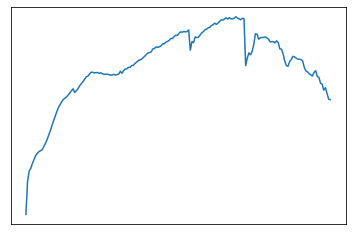

In [8]:
example = dataloader.__iter__().__next__()[0]
plt.plot(example)
plt.xticks([])
plt.yticks([])
plt.show()

## Autoencoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1):
        super(Encoder, self).__init__()

        # TODO: change architecture
        B = 188 # spectral bands
        R = 12  # endmembers
        self.encoder = nn.Sequential(
            nn.Linear(B, 9*R),
            nn.ReLU(),
            nn.Linear(9*R, 6*R),
            nn.ReLU(),
            nn.Linear(6*R, 3*R),
            nn.ReLU(),
            nn.Linear(3*R, R),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''
        Given a vector x, return the encoded latent representation h.

        Args:
            x: torch.tensor

        Return: 
            h: torch.tensor
        '''
        x = x.unsqueeze(0).unsqueeze(1)
        # print('encoder_input:', x.shape)  
        h = self.encoder(x)
        # print("h:",h.shape)

        return h

In [0]:
encoder = Encoder().to(device)
# summary(encoder, [(188)])

In [0]:
class Decoder(nn.Module):
    def __init__(self, out_channels=3, feat_dim=64):
        super(Decoder, self).__init__()

        B = 188 # spectral bands
        R = 12  # endmembers

        self.decoder = nn.Sequential(
          nn.Linear(R,B),
        )

    def forward(self, h):
        '''
        Given encoded vector h, return decoded vector x_hat

        Args:
            h: torch.tensor

        Return: 
            x_hat: torch.tensor
        '''
        # print('decoder input:', h.shape)
        x_hat = self.decoder(h)
        # access weights: https://discuss.pytorch.org/t/access-weights-of-a-specific-module-in-nn-sequential/3627
        # print('x_hat:', x_hat.shape)
        return x_hat

In [0]:
decoder = Decoder().to(device)
# summary(decoder, [(12)])

In [0]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=3, feat_dim=64):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(in_channels=1)
        self.decoder = Decoder()

    def forward(self, x):
        '''
        Compress and reconstruct the input image with encoder and decoder.

        Args:
            x: torch.tensor

        Return: 
            x_: torch.tensor
        '''

        h = self.encoder(x.to(device))
        x_hat = self.decoder(h)

        return x_hat

In [0]:
ae = Autoencoder().to(device)
# summary(ae, (3, 64, 64))

In [0]:
def visualize_recon(model, dataloader):
    '''
    Helper function for visualizing reconstruction performance.

    Randomly sample 8 images and plot the original/reconstructed images. 
    '''
    model.eval()

    inp_img = []
    out_img = []
    for i,img in enumerate(dataloader):
      if (i < 5):
        inp_img.append(img)
        out_img.append(model(img).squeeze(0).squeeze(0).detach().cpu())

    fig, ax = plt.subplots(2,5, figsize=(15,5))
    ax[0,0].plot(inp_img[0][0])
    ax[0,1].plot(inp_img[1][0])
    ax[0,2].plot(inp_img[2][0])
    ax[0,3].plot(inp_img[3][0])
    ax[0,4].plot(inp_img[4][0])

    ax[1,0].plot(out_img[0][0])
    ax[1,1].plot(out_img[1][0])
    ax[1,2].plot(out_img[2][0])
    ax[1,3].plot(out_img[3][0])
    ax[1,4].plot(out_img[4][0])

    model.train()
    plt.show()

In [0]:
def train_ae(model, dataloader, epochs=100):
    '''
    Train autoencoder model.

    Args:
        model: torch.nn.module.
        dataloader: DataLoader. The unlabeled partition of the STL dataset.
    '''

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    loss_traj = []

    for epoch in tqdm(range(epochs)):

        loss_epoch = 0
        for x in dataloader:

            inp = x[0].to(device)

            out = model(inp)

            loss = criterion(out, inp.unsqueeze(0).unsqueeze(1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        
        if epoch % 10 == 0:
            output.clear()
            print('\nEpoch {}, loss {:.3f}'.format(epoch, loss_epoch))
            visualize_recon(model, dataloader)

    return model, loss_traj, out, inp


Epoch 90, loss 20.419


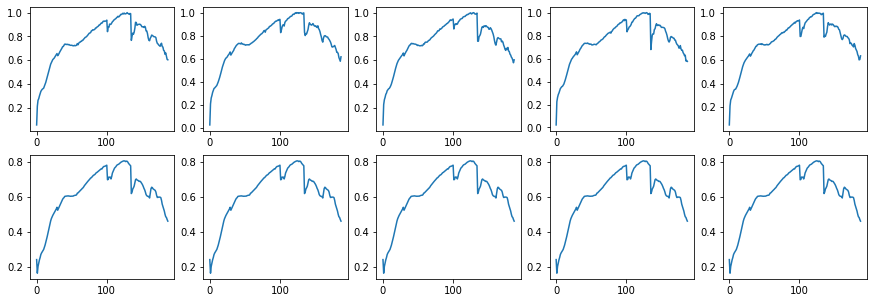

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


In [143]:
# Train the autoencoder for 100 epochs
ae = Autoencoder().to(device)
ae, ae_loss_traj, out, inp = train_ae(ae, dataloader, epochs=100)

In [123]:
B = 188
R = 12
for layer in ae.modules():
  if isinstance(layer, nn.Linear):
    print(layer)
    if (layer.out_features == B):
      M = layer.weight.detach().cpu().numpy()
print(M.shape)
print(M)

Linear(in_features=188, out_features=108, bias=True)
Linear(in_features=108, out_features=72, bias=True)
Linear(in_features=72, out_features=36, bias=True)
Linear(in_features=36, out_features=12, bias=True)
Linear(in_features=12, out_features=188, bias=True)
(188, 12)
[[-0.16190846  0.08014353 -0.0741105  ...  0.02402054 -0.21875538
   0.22948663]
 [-0.11533909  0.05075086 -0.01567417 ... -0.30040038  0.23111027
  -0.1508637 ]
 [ 0.08107707  0.19347838  0.07169899 ... -0.25776723 -0.03269307
   0.22822177]
 ...
 [ 0.08284626 -0.01236961  0.12022433 ... -0.11121204  0.20258008
   0.21956111]
 [ 0.01388905  0.15098022  0.22857186 ...  0.0600818  -0.04454871
  -0.00438186]
 [-0.09103765 -0.03744379 -0.26496658 ...  0.24075654  0.22965482
   0.12375191]]
